# Shrnutí problému
---

## Základní definice problému

Máme n subjektů, které tvoří energetickou komunitu. Subjekty v této komunitě sdílí energii, kterou vytvoří a nespotřebují, se subjekty, které jsou v nedostatku. Sdílení energie probíhá každých 15 minut za pomocí alokačního klíče, *který skupina musí předložít na měsíc dopředu*. Algoritmus, podle kterého přerozdělování funguje, může být znázorněn následovně:

- Zjistit kolik energie je k dispozici a jaká je poptávka po energii.
- Přerozdělit energii podle alokačního klíče:
   - Klíč je dynamický?
      - Energie se přerozdělí v poměru momentálních potřeb subjektů.
   - Klíč je statický?
      - následuje 5 kol přerozdělování podle předem předložených poměrů. Energie, která se nespotřebuje v prvním kole, se posune do druhého kola a podle stejných poměrů se přerozdělí.
      - Tento proces trvá do doby dokud není přerozdělená všechna energie, nebo nevyčerpáme všech 5 pokusů na přerozdělení.
- Přebytek energie, který se nerozdělil se vybije do sítě.

### Cíl

Cílem našeho snažení je vytvořit takový alokační klíč, který bude minimalizovat množství energie, která se nevyužije v rámci skupiny.

## Popis simulace

### Alokační klíč

Alokační klíč určuje způsob výpočtu elektřiny sdílené mezi jednotlivými předávacími místy (dodavatelem a odběratelem). Existují tři typy alokačních klíčů:

- Statický: Alokace podle definovaných procent pro každého odběratele.
- Dynamický: Alokace podle poměru spotřeby jednotlivých odběratelů.
- Hybridní: Kombinace statické a dynamické alokace.

Zde jsme se snažili simulovat proces simulace a ne něm demostrovat, zda-li jsme správně pochopili použítí alokačních klíčů.

In [1]:
# This is the process of one timestamp allocation with priority matrix.

def step(available_energy, remaining_demand, weights_df, preferences_df, rounds=5):
    producers = available_energy.index
    consumers = remaining_demand.index

    weights = weights_df.loc[consumers, producers].T.values
    preferences = preferences_df.loc[producers, consumers].values

    for _ in range(rounds):
        allocation = available_energy.values[:, None] * weights

        for j in range(len(consumers)):
            pref = preferences[:, j]
            sorted_idx = np.argsort(-pref)
            for i in sorted_idx:
                if pref[i] <= 0 or remaining_demand.iloc[j] <= 0:
                    continue
                transfer = min(allocation[i, j], remaining_demand.iloc[j])
                remaining_demand.iloc[j] -= transfer
                available_energy.iloc[i] -= transfer
                allocation[i, j] -= transfer

    return remaining_demand, available_energy

In [2]:
import numpy as np

total_prebytek = 1000  # Available surplus energy
nedostatek = np.array([90., 150., 50., 110., 30., 570.])  # Energy deficit for different units
alokacni_klic = np.array([0.1, 0.2, 0.05, 0.1, 0.05, 0.5])  # Allocation key
kola = ['1. Kolo', '2. Kolo', '3. Kolo', '4. Kolo', '5. Kolo']

def static(total_prebytek, alokacni_klic, nedostatek, kolo):
    print("\n" + "="*70)
    print(f"{kolo}: Distribuce Energie")
    print("="*70)

    allocation = np.minimum(total_prebytek * alokacni_klic, nedostatek)

    print(f"Celková nerozdělená energie:  {total_prebytek:.2f} MWh")
    print(f"Nedostatek energie :          {' | '.join(map(str, np.round(nedostatek, 2)))}")
    print(f"Alokační klíč:                {' | '.join(map(str, np.round(alokacni_klic, 2)))}")
    print(f"Alokovaná energie:            {' | '.join(map(str, np.round(allocation, 2)))}")

    nedostatek = nedostatek - allocation
    total_prebytek -= np.sum(allocation)

    return total_prebytek, alokacni_klic, nedostatek

def dynamic(total_prebytek, nedostatek):
    total_deficit = nedostatek.sum()
    alokacni_klic = nedostatek / total_deficit
    allocation = np.minimum(total_prebytek * alokacni_klic, nedostatek)

    print("\n" + "="*70)
    print("Dynamický Alokační Strategie")
    print("="*70)

    print(f"Celková nerozdělená energie:  {total_prebytek:.2f} MWh")
    print(f"Nedostatek energie :          {' | '.join(map(str, np.round(nedostatek, 2)))}")
    print(f"Alokační klíč:                {' | '.join(map(str, np.round(alokacni_klic, 2)))}")
    print(f"Alokovaná energie:            {' | '.join(map(str, np.round(allocation, 2)))}")

    nedostatek = nedostatek - allocation
    total_prebytek -= np.sum(allocation)

    return total_prebytek, nedostatek

def hybrid(total_prebytek, alokacni_klic, nedostatek):
    print("\n1. Kolo Statické strategie")
    total_prebytek, alokacni_klic, nedostatek = static(total_prebytek, alokacni_klic, nedostatek, 1)
    print("\n2. Kolo Dynamické strategie")
    total_prebytek, nedostatek = dynamic(total_prebytek, nedostatek)
    print("\nFinalní status po konce distribuce.")
    print("Zbývající nedostatek: ", " | ".join(map(str, np.round(nedostatek, 2))))

print("\nStatická Alokační Strategie")
print("="*70)

for kolo in kola:
    total_prebytek, alokacni_klic, nedostatek = static(total_prebytek, alokacni_klic, nedostatek, kolo)
    if total_prebytek <= 0:
        print("\nVšechna energie byla přerozdělena.")
        break

print("\nFinalní status po konce distribuce.")
print("Zbývající nedostatek: ", " | ".join(map(str, np.round(nedostatek, 2))))



Statická Alokační Strategie

1. Kolo: Distribuce Energie
Celková nerozdělená energie:  1000.00 MWh
Nedostatek energie :          90.0 | 150.0 | 50.0 | 110.0 | 30.0 | 570.0
Alokační klíč:                0.1 | 0.2 | 0.05 | 0.1 | 0.05 | 0.5
Alokovaná energie:            90.0 | 150.0 | 50.0 | 100.0 | 30.0 | 500.0

2. Kolo: Distribuce Energie
Celková nerozdělená energie:  80.00 MWh
Nedostatek energie :          0.0 | 0.0 | 0.0 | 10.0 | 0.0 | 70.0
Alokační klíč:                0.1 | 0.2 | 0.05 | 0.1 | 0.05 | 0.5
Alokovaná energie:            0.0 | 0.0 | 0.0 | 8.0 | 0.0 | 40.0

3. Kolo: Distribuce Energie
Celková nerozdělená energie:  32.00 MWh
Nedostatek energie :          0.0 | 0.0 | 0.0 | 2.0 | 0.0 | 30.0
Alokační klíč:                0.1 | 0.2 | 0.05 | 0.1 | 0.05 | 0.5
Alokovaná energie:            0.0 | 0.0 | 0.0 | 2.0 | 0.0 | 16.0

4. Kolo: Distribuce Energie
Celková nerozdělená energie:  14.00 MWh
Nedostatek energie :          0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 14.0
Alokační klíč:         

In [3]:
print("\n\nDynamická alokační strategie")
print("="*70)

total_prebytek = 1000  # Reset initial energy
nedostatek = np.array([90., 150., 50., 110., 30., 570.])
total_prebytek, nedostatek = dynamic(total_prebytek, nedostatek)

print("\nFinalní status po konce distribuce.")
print("Zbývající nedostatek: ", " | ".join(map(str, np.round(nedostatek, 2))))



Dynamická alokační strategie

Dynamický Alokační Strategie
Celková nerozdělená energie:  1000.00 MWh
Nedostatek energie :          90.0 | 150.0 | 50.0 | 110.0 | 30.0 | 570.0
Alokační klíč:                0.09 | 0.15 | 0.05 | 0.11 | 0.03 | 0.57
Alokovaná energie:            90.0 | 150.0 | 50.0 | 110.0 | 30.0 | 570.0

Finalní status po konce distribuce.
Zbývající nedostatek:  0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0


In [4]:
print("\nHybridní Alokační strategie")
print("="*70)
total_prebytek = 1000  # Reset initial energy
nedostatek = np.array([90., 150., 50., 110., 30., 570.])
hybrid(total_prebytek, alokacni_klic, nedostatek)


Hybridní Alokační strategie

1. Kolo Statické strategie

1: Distribuce Energie
Celková nerozdělená energie:  1000.00 MWh
Nedostatek energie :          90.0 | 150.0 | 50.0 | 110.0 | 30.0 | 570.0
Alokační klíč:                0.1 | 0.2 | 0.05 | 0.1 | 0.05 | 0.5
Alokovaná energie:            90.0 | 150.0 | 50.0 | 100.0 | 30.0 | 500.0

2. Kolo Dynamické strategie

Dynamický Alokační Strategie
Celková nerozdělená energie:  80.00 MWh
Nedostatek energie :          0.0 | 0.0 | 0.0 | 10.0 | 0.0 | 70.0
Alokační klíč:                0.0 | 0.0 | 0.0 | 0.12 | 0.0 | 0.88
Alokovaná energie:            0.0 | 0.0 | 0.0 | 10.0 | 0.0 | 70.0

Finalní status po konce distribuce.
Zbývající nedostatek:  0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0


### Přidání priorit do alokačního klíče

#### Definice priorit: 

Každému odběrateli se přiřazuje index priority, který určuje pořadí, v jakém bude elektřina alokována. Čím vyšší priorita, tím dříve bude odběratel zásobeno elektřinou.

##### Typ 1: Priority na straně spotřeby

Přebytek energie se vezme dohromady a rozděluje se podle priority.

In [5]:
import numpy as np

# Počáteční data
prebytek  = np.array([200., 100., 50., 400., 250.])
nedostatek = np.array([90., 150., 50., 110., 30., 570.])  # Nedostatek energie
alokacni_klic = np.array([0.1, 0.2, 0.05, 0.1, 0.05, 0.5])  # Původní alokační klíč
priority = np.array([3, 1, 4, 2, 5, 1])  # Priority (vyšší číslo = vyšší priorita)

# Seřazení indexů podle priority (od nejvyšší po nejnižší)

sorted_indices = np.argsort(-priority)  
total_prebytek = prebytek.sum()  # Dostupný přebytek energie

# Seřazení všech polí podle priorit

nedostatek = nedostatek[sorted_indices]
alokacni_klic = alokacni_klic[sorted_indices]
priority = priority[sorted_indices]

kola = ['1. Kolo', '2. Kolo', '3. Kolo', '4. Kolo', '5. Kolo']

def static(total_prebytek, alokacni_klic, nedostatek, kolo):
    print("\n" + "="*70)
    print(f"{kolo}: Distribuce energie")
    print("="*70)
    allocation = np.zeros_like(nedostatek)
    print(f"Celková nerozdělená energie:  {total_prebytek:.2f} MWh")
    print(f"Nedostatek energie :          {' | '.join(map(str, np.round(nedostatek, 2)))}")
    print(f"Alokační klíč:                {' | '.join(map(str, np.round(alokacni_klic, 2)))}")

    # Iterativní alokace podle priorit
    for i in range(len(nedostatek)):
        allocated = min(total_prebytek * alokacni_klic[i], nedostatek[i])
        allocation[i] = allocated
        total_prebytek -= allocated
        nedostatek[i] -= allocated
        if total_prebytek <= 0:
            break  # Přebytek vyčerpán

    print(f"Alokovaná energie:            {' | '.join(map(str, np.round(allocation, 2)))}")

    return total_prebytek, alokacni_klic, nedostatek

print("\nStatická alokace s prioritami")
print("="*70)

print(f'Priority:           {"    | ".join(map(str, priority))}')
print(f'Nedostatek energie: {" | ".join(map(str, np.round(nedostatek, 2)))}')
for kolo in kola:
    total_prebytek, alokacni_klic, nedostatek = static(total_prebytek, alokacni_klic, nedostatek, kolo)
    if total_prebytek <= 0:
        ("\nVšechna energie byla přerozdělena.")
        break

print("\nFinalní status po konce distribuce.")
print("Zbývající nedostatek: ", " | ".join(map(str, np.round(nedostatek, 2))))



Statická alokace s prioritami
Priority:           5    | 4    | 3    | 2    | 1    | 1
Nedostatek energie: 30.0 | 50.0 | 90.0 | 110.0 | 150.0 | 570.0

1. Kolo: Distribuce energie
Celková nerozdělená energie:  1000.00 MWh
Nedostatek energie :          30.0 | 50.0 | 90.0 | 110.0 | 150.0 | 570.0
Alokační klíč:                0.05 | 0.05 | 0.1 | 0.1 | 0.2 | 0.5
Alokovaná energie:            30.0 | 48.5 | 90.0 | 83.15 | 149.67 | 299.34

2. Kolo: Distribuce energie
Celková nerozdělená energie:  299.34 MWh
Nedostatek energie :          0.0 | 1.5 | 0.0 | 26.85 | 0.33 | 270.66
Alokační klíč:                0.05 | 0.05 | 0.1 | 0.1 | 0.2 | 0.5
Alokovaná energie:            0.0 | 1.5 | 0.0 | 26.85 | 0.33 | 135.33

3. Kolo: Distribuce energie
Celková nerozdělená energie:  135.33 MWh
Nedostatek energie :          0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 135.33
Alokační klíč:                0.05 | 0.05 | 0.1 | 0.1 | 0.2 | 0.5
Alokovaná energie:            0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 67.67

4. Kolo: Distribuc

##### Typ 2: Priorita na straně výroby

Každý dodavatel přiřadí index priority, který určuje pořadí, v jakém bude elektřina alokována. V tomto případě pracujeme s prioritami, jako s maticí.

In [6]:
producers = ["Producent 1", "Producent 2", "Producent 3", "Producent 4", "Producent 5"]
consumers = ["Odběratel A", "Odběratel B", "Odběratel C", "Odběratel D", "Odběratel E", "Odběratel F"]

prebytek  = np.array([200., 100., 50., 400., 250.])  # Dostupná energie od jednotlivých výrobců
nedostatek = np.array([90., 150., 50., 110., 30., 570.])  # Nedostatek energie u odběratelů
priority_matice = np.array([
    [3, 1, 2, 4, 5, 6],  # Výrobce 1
    [2, 3, 1, 5, 6, 4],  # Výrobce 2
    [5, 6, 4, 3, 2, 1],  # Výrobce 3
    [1, 2, 3, 4, 5, 6],  # Výrobce 4
    [4, 5, 6, 1, 2, 3]   # Výrobce 5
])  # Matice priorit (řádky = výrobci, sloupce = odběratelé)

kola = ['1. Kolo', '2. Kolo', '3. Kolo', '4. Kolo', '5. Kolo']

def distribute_producer_energy(energy_available, priority_row, nedostatek):
    """ Přerozdělení energie výrobce mezi odběratele podle priority. """
    allocation = np.zeros_like(nedostatek)
    
    # Seřadíme indexy podle priority (vyšší číslo = vyšší priorita)
    sorted_indices = np.argsort(-priority_row)

    for i in sorted_indices:
        if energy_available <= 0:
            break  # Výrobce už nemá žádnou energii

        allocated = min(energy_available, nedostatek[i])
        allocation[i] = allocated
        energy_available -= allocated
        nedostatek[i] -= allocated

    return allocation, nedostatek, energy_available

def static(prebytek, nedostatek, kolo):
    print("\n" + "="*70)
    print(f"{kolo}: Alokace energie s prioritami")
    print("="*70)

    allocation_matrix = np.zeros((len(producers), len(consumers)), dtype=float)
    
    print("\nDostupná energie od producentů:")
    for i, amount in enumerate(prebytek):
        print(f"   {producers[i]:>10}: {amount:.2f} MWh")

    print("\nEnergetický nedostatek spotřebitelů:")
    for i, amount in enumerate(nedostatek):
        print(f"   {consumers[i]:>10}: {amount:.2f} MWh")

    # Výpis prioritní matice
    print("\nMatice Priorit:")
    print(" " * 12 + " | ".join([f"{c:^10}" for c in consumers]))
    print("=" * 70)
    for i, row in enumerate(priority_matice):
        print(f"{producers[i]:>10} | " + " | ".join([f"{p:^10}" for p in row]))

    # Každý výrobce přerozdělí svou energii podle priorit
    for i in range(len(producers)):
        allocation, nedostatek, prebytek[i] = distribute_producer_energy(prebytek[i], priority_matice[i], nedostatek)
        allocation_matrix[i] = allocation  # Ukládáme alokaci do matice

    # Výpis alokační matice
    print("\nMatice alokace:")
    print(" " * 12 + " | ".join([f"{c:^10}" for c in consumers]))
    print("=" * 70)
    for i, row in enumerate(allocation_matrix):
        print(f"{producers[i]:>10} | " + " | ".join([f"{a:^10.2f}" for a in row]))

    return prebytek, nedostatek

print("\nStatická alokace s prioritami")
print("="*70)

for kolo in kola:
    prebytek, nedostatek = static(prebytek, nedostatek, kolo)
    if prebytek.sum() <= 0:
        print("\nVšechna energie byla přerozdělena.")
        break

print("\nFinalní status po konce distribuce.")
print("Zbývající nedostatek: ", " | ".join(map(str, np.round(nedostatek, 2))))
for i, amount in enumerate(nedostatek):
    print(f"   {consumers[i]:>10}: {amount:.2f} MWh")



Statická alokace s prioritami

1. Kolo: Alokace energie s prioritami

Dostupná energie od producentů:
   Producent 1: 200.00 MWh
   Producent 2: 100.00 MWh
   Producent 3: 50.00 MWh
   Producent 4: 400.00 MWh
   Producent 5: 250.00 MWh

Energetický nedostatek spotřebitelů:
   Odběratel A: 90.00 MWh
   Odběratel B: 150.00 MWh
   Odběratel C: 50.00 MWh
   Odběratel D: 110.00 MWh
   Odběratel E: 30.00 MWh
   Odběratel F: 570.00 MWh

Matice Priorit:
            Odběratel A | Odběratel B | Odběratel C | Odběratel D | Odběratel E | Odběratel F
Producent 1 |     3      |     1      |     2      |     4      |     5      |     6     
Producent 2 |     2      |     3      |     1      |     5      |     6      |     4     
Producent 3 |     5      |     6      |     4      |     3      |     2      |     1     
Producent 4 |     1      |     2      |     3      |     4      |     5      |     6     
Producent 5 |     4      |     5      |     6      |     1      |     2      |     3     

Mati

## Otázky Ohledně algoritmu

1. Existuje omezení na počet subjektů, které mohou přijmout a dodat energii jednomu subjektu?
2. Může jeden subjekt poskytnout/přijmout energii více subjektům naráz, nebo je to jedno kolo jeden subjekt?
3. Jak přesně fungují priority? Jsou ve výstupu algoritmů správně v prvním, nebo ve druhém případě?
4. Jak přesně vypadá alokační klíč?
   - Jaká je jeho technická implementace?
5. Jsou priority součastí alokačního klíče? 
   - Musíme dodat alokační klíč (vektor proporcí) a společně s ním priority?
6. Můžeme priority měnit dynamicky? (Stejně jako dynamický klíč)

## Analýza poskytnutých dat

V této sekci jsme chtěli uvést základní grafy, které vykreslují poskytnutá data a poukáží na možné úskalí problému a na jeho další možné rozšíření.

#### 1. Jak vypadá denní spotřeba a denní výroba energie

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import numpy as np

sns.set_theme(style="whitegrid")

def create_plots(data: pd.DataFrame, columns: List[str], title: str, save, path, zero, window: int = 0):

    # Apply rolling mean if window > 1
    if window > 1:
        sum_prod_cons_smoothed = data.rolling(window=window).mean()
    else:
        sum_prod_cons_smoothed = data
    
    # Create the figure with a size for better visual clarity
    fig = plt.figure(figsize=(12, 8))
    
    # Plot each column
    for col in columns:
        # Add "(smoothed)" to the label if smoothing is applied
        label = f'{col}' if window > 1 else col
        
        # Use a different line style for smoothed data
        line_style = '-' if window > 1 else '-'
        
        plt.plot(sum_prod_cons_smoothed.index, sum_prod_cons_smoothed[col], label=label, linestyle=line_style, linewidth=2)
    if zero:
        plt.plot(sum_prod_cons_smoothed.index, np.array([0]*len(sum_prod_cons_smoothed.index)), color='black', linestyle='--', linewidth=1.5)
    # Customize the legend with better readability
    plt.legend(loc='upper left', fontsize=12)

    # Add the title with a larger font size for better emphasis
    plt.title(title, fontsize=16)

    # Add axis labels
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Energy (MWh)', fontsize=14)

    # Customize grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Ensure tight layout for a cleaner fit
    plt.tight_layout()

    # Show the plot
    if save:
        plt.savefig(path)
    plt.show()


data = pd.read_csv('data/outputs/production_consumption.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
cons_columns = [col for col in data.columns if 'cons' in col]
prod_columns = [col for col in data.columns if 'prod' in col]

data['Spotřeba'] = data[cons_columns].sum(axis=1)
data['Výroba'] = data[prod_columns].sum(axis=1)
data['date'] = data['timestamp'].dt.date

data_agg = data[['date', 'Spotřeba', 'Výroba']].groupby('date').sum()

create_plots(data_agg, ['Spotřeba', 'Výroba'], 'Denní vývoj Výroby a Spotřeby', True, 'daily_prod_cons.png', False)
create_plots(data_agg, ['Spotřeba', 'Výroba'], 'Týdenní vyhlazený průměr denní Výroby a Spotřeby', True, 'daily_prod_cons_smooth.png', False, window=7)




FileNotFoundError: [Errno 2] No such file or directory: 'data/outputs/production_consumption.csv'

#### 2. Jak vypadá denní nedostatek a přebytek energie

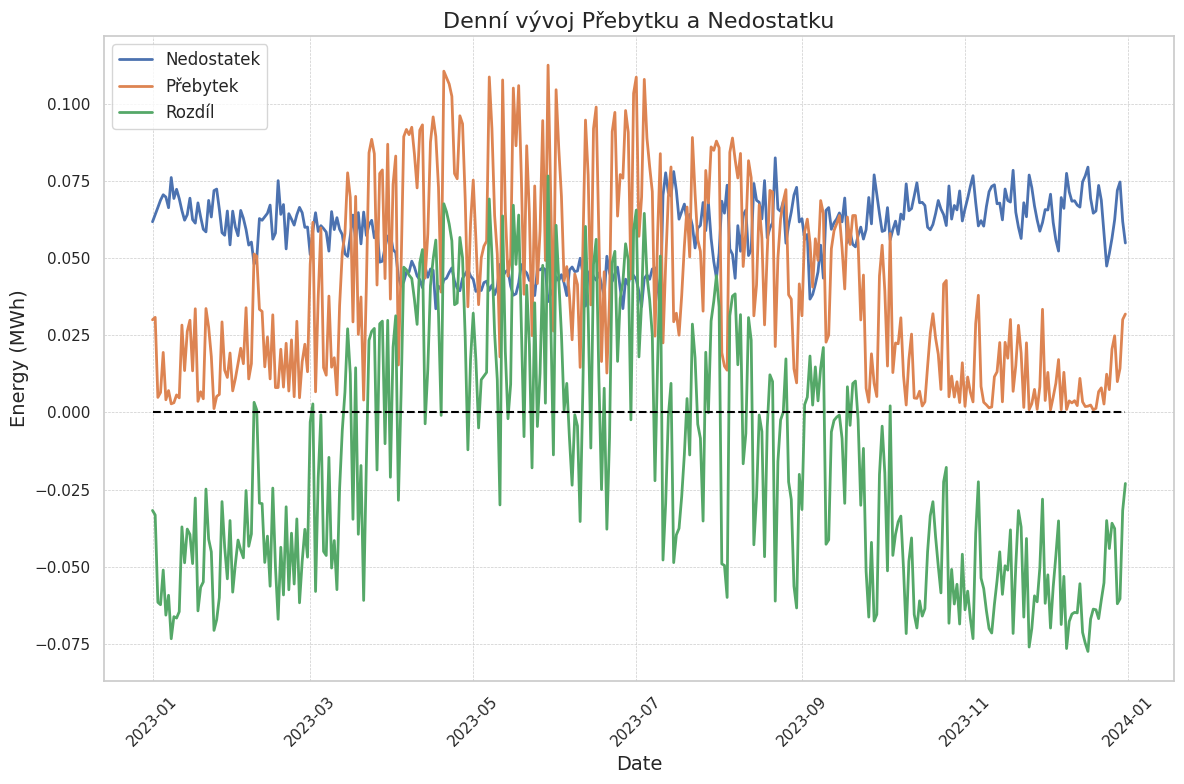

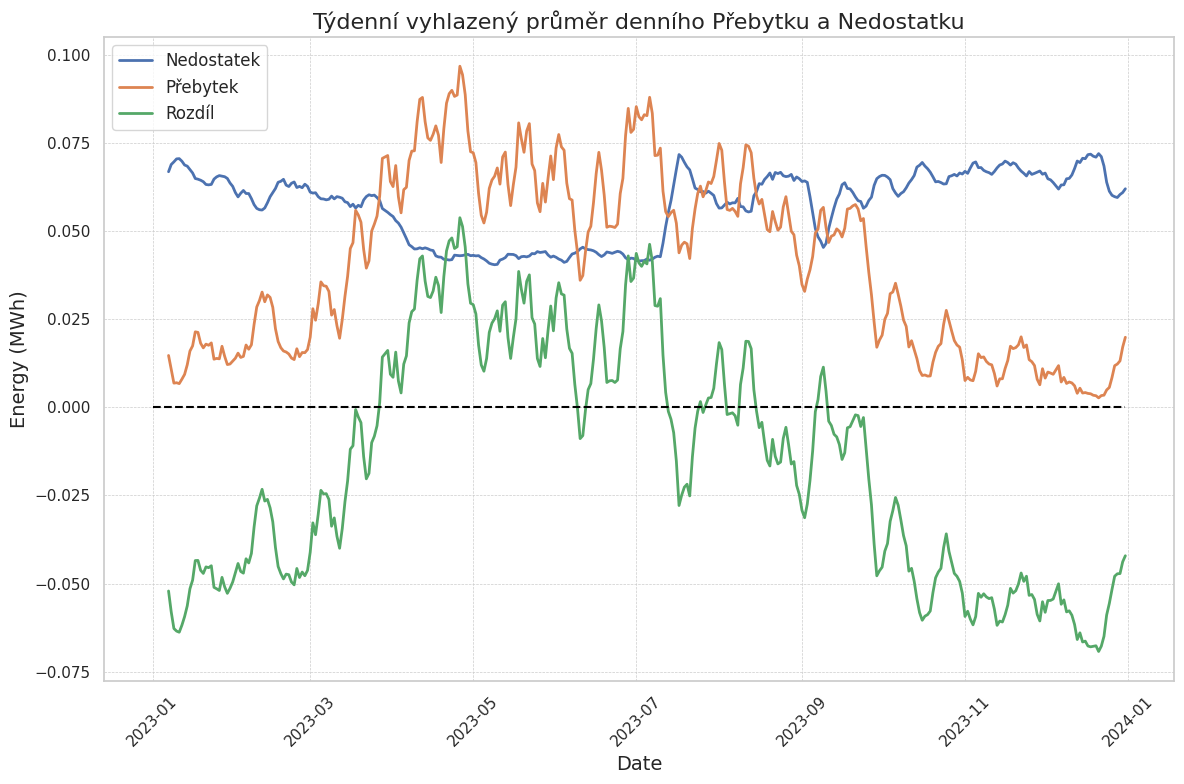

In [199]:
excess = pd.read_csv('/home/miro/Bachelor/BT/Analysis/data/outputs/excess.csv')
deficit = pd.read_csv('/home/miro/Bachelor/BT/Analysis/data/outputs/deficit.csv')
yearly_cons = pd.read_csv('/home/miro/Bachelor/BT/Analysis/data/outputs/yearly_consumption.csv')

excess['timestamp'] = pd.to_datetime(excess['timestamp'])
excess.set_index('timestamp', inplace=True)
deficit['timestamp'] = pd.to_datetime(deficit['timestamp'])
deficit.set_index('timestamp', inplace=True)

deficit = deficit.astype(float)
excess = excess.astype(float)

agg_data = deficit.sum(axis=1).to_frame()
agg_data = agg_data.rename(columns={agg_data.columns[0] : 'Nedostatek'})
agg_data['Přebytek'] = excess.sum(axis=1)

agg_data = agg_data.reset_index()
agg_data['date'] = agg_data['timestamp'].dt.date
agg_data['Rozdíl'] = agg_data['Přebytek'] - agg_data['Nedostatek']

daily_avg = agg_data.groupby('date')[['Nedostatek', 'Přebytek', 'Rozdíl']].mean()

agg_data = deficit.sum(axis=1).to_frame()
agg_data = agg_data.rename(columns={agg_data.columns[0] : 'Nedostatek'})
agg_data['Přebytek'] = excess.sum(axis=1)
agg_data = agg_data.reset_index()
agg_data['date'] = agg_data['timestamp'].dt.date
agg_data['Rozdíl'] = agg_data['Přebytek'] - agg_data['Nedostatek']
agg_data['hour'] = agg_data['timestamp'].dt.hour
agg_data['minute'] = agg_data['timestamp'].dt.minute

average_day = agg_data.groupby(['hour', 'minute'])[['Nedostatek', 'Přebytek', 'Rozdíl']].mean()
average_day['time'] = average_day.index.map(lambda x: f'{x[0]:02}:{x[1]:02}')

create_plots(daily_avg,['Nedostatek', 'Přebytek', "Rozdíl"], 'Denní vývoj Přebytku a Nedostatku', True, 'daily_deficit_excess.png', True)
create_plots(daily_avg,['Nedostatek', 'Přebytek', "Rozdíl"], 'Týdenní vyhlazený průměr denního Přebytku a Nedostatku', True, 'daily_deficit_excess_smaooth.png',True, window=7)


#### 3. Jak vypadá průměrný den?

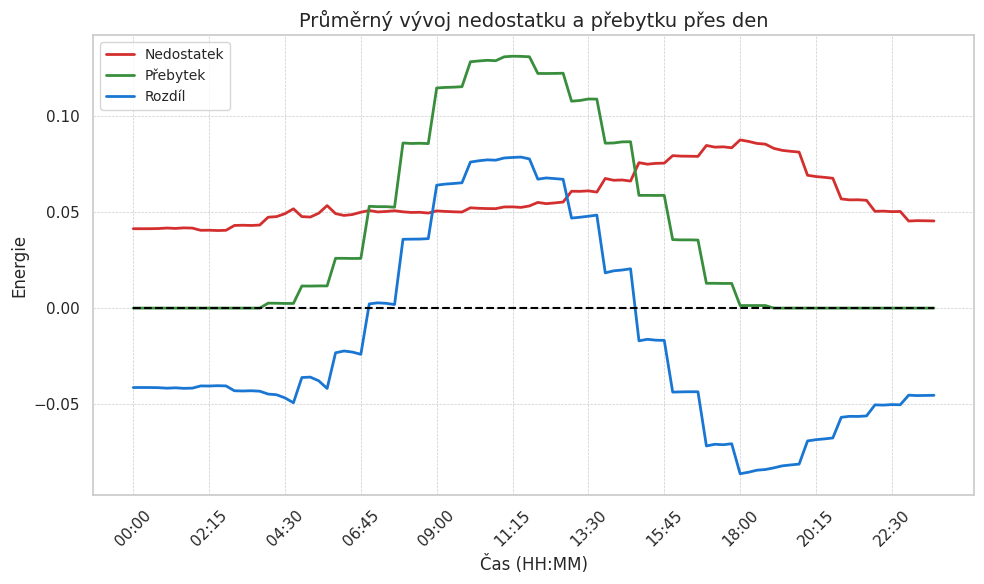

In [201]:
plt.figure(figsize=(10, 6))

plt.plot(average_day['time'], average_day['Nedostatek'], label='Nedostatek', color='#D32F2F', linewidth=2)
plt.plot(average_day['time'], average_day['Přebytek'], label='Přebytek', color='#388E3C', linewidth=2)
plt.plot(average_day['time'], average_day['Rozdíl'], label='Rozdíl', color='#1976D2', linewidth=2)

plt.plot(average_day['time'], np.array([0]*len(average_day['time'])), color='black', linestyle='--', linewidth=1.5)

plt.ylabel('Energie', fontsize=12)
plt.xlabel('Čas (HH:MM)', fontsize=12)
plt.title('Průměrný vývoj nedostatku a přebytku přes den', fontsize=14)

plt.legend(loc='upper left', fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(range(0, len(average_day['time']), len(average_day['time']) // 10),
           average_day['time'][::len(average_day['time']) // 10], rotation=45)

plt.tight_layout()
plt.savefig('avg_day.png')


#### 4. Jak si vede statický klíč?

In [213]:
def sequential_simple_model(excess, deficit, method, steps, yearly_cons):

    result_df = pd.DataFrame(columns=['Total Excess', 'Total Deficit', 'Excess - Deficit', 'Optimal Residual', 'True Residual', 'Average steps'])
    result_df.index.name = "Timestamp"

    common_timestamps = deficit.index.intersection(excess.index)
    deficit = deficit.loc[common_timestamps]
    excess = excess.loc[common_timestamps]

    for time_stamp in deficit.index:
        e_t = excess.loc[time_stamp]
        d_t = deficit.loc[time_stamp]
        total_allocation, step = method(e_t, d_t, steps, yearly_cons)
        result_df.loc[time_stamp] = [excess.loc[time_stamp].sum(),
                                     deficit.loc[time_stamp].sum(),
                                    excess.loc[time_stamp].sum() - deficit.loc[time_stamp].sum(),
                                    np.max([deficit.loc[time_stamp].sum() - excess.loc[time_stamp].sum(), 0]),
                                    deficit.loc[time_stamp].sum() - total_allocation,
                                    step]
    
    return result_df

def waterfall(e_t, d_t, steps, yearly_cons):
        total_deficit = d_t.sum()
        total_excess = e_t.sum()
        total_allocation = 0

        for step in range(steps):
            if ((total_deficit > 0) and (total_excess > 0)):
            
                p = d_t/total_deficit
                allocation = np.minimum(total_excess * p, d_t)
                d_t = d_t - allocation

                proportion = e_t / np.sum(e_t)
                proportion = np.nan_to_num(proportion, nan=0.0)
                R_t = np.outer(proportion, allocation)
                e_t = e_t - np.sum(R_t, axis=1)

                total_allocation += allocation.sum()
                total_deficit -= allocation.sum()
                total_excess  -= allocation.sum()

            else:
                break
        
        return total_allocation, step

def fixed_rate(e_t, d_t, steps, yearly_cons):
    yearly_cons_dict = yearly_cons.set_index('Column')['Y_cons'].to_dict()
    p = pd.Series(yearly_cons_dict).reindex(deficit.columns, fill_value=0)
    p /= p.sum()

    total_deficit = d_t.sum()
    total_excess = e_t.sum()
    total_allocation = 0

    for step in range(steps):
        if ((total_deficit > 0) and (total_excess > 0)):
            allocation = np.minimum(total_excess * p, d_t)
            d_t = d_t - allocation
            
            proportion = e_t / np.sum(e_t)
            R_t = np.outer(proportion, allocation)
            e_t = e_t - np.sum(R_t, axis=1)

            total_allocation += allocation.sum()
            total_deficit -= allocation.sum()
            total_excess  -= allocation.sum()

        else:
            break
    
    return total_allocation, step




In [214]:
fixed_df = sequential_simple_model(excess, deficit, fixed_rate, 5, yearly_cons)
aggregated = fixed_df.agg({
    'Optimal Residual': 'sum',
    'True Residual': 'sum',
    'Average steps': 'mean'
}).reset_index()


styled_aggregated = aggregated.style.format({
    'Optimální rozdíl mezi přebytkem a nedostatek': '{:,.2f}',
    'Rozdíl mezi přebytkem a nedostatek rozděleným podle statického klíče': '{:,.2f}',
    'Průměrný počet kroků': '{:.2f}'
})


print(styled_aggregated.to_latex())

\begin{tabular}{llr}
 & index & 0 \\
0 & Optimal Residual & 1479.124137 \\
1 & True Residual & 1484.279223 \\
2 & Average steps & 1.497317 \\
\end{tabular}



#### 5. Jak si vede dynamický klíč?

Zde jsme se snažili ukázat, jak se daří dynamickému klíči na našich datech.


In [215]:
waterfall_df = sequential_simple_model(excess, deficit, waterfall, 1, yearly_cons)

aggregated = waterfall_df.agg({
    'Optimal Residual': 'sum',
    'True Residual': 'sum',
    'Average steps': 'mean'
}).reset_index()

styled_aggregated = aggregated.style.format({
    'Optimal Residual': '{:,.2f}',  
    'True Residual': '{:,.2f}',
    'Average steps': '{:.2f}'       
})


print(styled_aggregated.to_latex())

\begin{tabular}{llr}
 & index & 0 \\
0 & Optimal Residual & 1479.124137 \\
1 & True Residual & 1479.124137 \\
2 & Average steps & 0.000000 \\
\end{tabular}



In [221]:
print(np.round(waterfall_df.sum(), 2).to_frame().style.to_latex())

\begin{tabular}{lr}
 & 0 \\
Total Excess & 1428.390000 \\
Total Deficit & 2013.300000 \\
Excess - Deficit & -584.910000 \\
Optimal Residual & 1479.120000 \\
True Residual & 1479.120000 \\
Average steps & 0.000000 \\
\end{tabular}



In [205]:
excess.sum().sum()

np.float64(1428.3885802846494)